In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 

For now we only have example with one file. We will use catalog

In [2]:
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [3]:
data_oce = eerie_cat["dkrz"]["disk"]["model-output"]["icon-esm-er"]["eerie-control-1950"]["ocean"]["native"]["2d_monthly_mean"].to_dask()

def prep_data(ds):
    ds = ds.rename({"ncells": "cell"})
    return ds

data = prep_data(data_oce)
data

<xarray.Dataset>
Dimensions:                              (time: 456, lev: 1, cell: 14886338,
                                          depth: 1, ncells_2: 22375924)
Coordinates:
  * depth                                (depth) float64 1.0
    lat                                  (cell) float64 dask.array<chunksize=(14886338,), meta=np.ndarray>
  * lev                                  (lev) float64 0.0
    lon                                  (cell) float64 dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time                                 (time) datetime64[ns] 2002-01-31T23:...
Dimensions without coordinates: cell, ncells_2
Data variables: (12/35)
    Qbot                                 (time, lev, cell) float32 dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    Qtop                                 (time, lev, cell) float32 dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    Wind_Speed_10m                       (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Evaporation    (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Precipitation  (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    atmos_fluxes_FrshFlux_Runoff         (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    ...                                   ...
    sea_level_pressure                   (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    so                                   (time, depth, cell) float32 dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    ssh                                  (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    stretch_c                            (time, cell) float32 dask.array<chunksize=(5, 4976640), meta=np.ndarray>
    to                                   (time, depth, cell) float32 dask.array<chunksize=(4, 1, 6967296), meta=np.ndarray>
    verticallyTotal_mass_flux_e          (time, ncells_2) float32 dask.array<chunksize=(5, 5099520), meta=np.ndarray>
Attributes: (12/35)
    CDI:                      Climate Data Interface version 2.2.0 (https://m...
    Conventions:              CF-1.6
    DOKU_License:             CC BY 4.0
    DOKU_Name:                EERIE ICON-ESM-ER eerie-control-1950 run
    DOKU_authors:             Putrasahan, D.; Kröger, J.; Wachsmann, F.
    DOKU_responsible_person:  Fabian Wachsmann
    ...                       ...
    time_max:                 29498399
    time_min:                 27394559
    time_reduction:           mean
    title:                    ICON simulation
    uri:                      /work/bm1344/k203123/experiments/erc1011/run_20...
    uuidOfHGrid:              375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b

In [4]:
grid = xr.open_dataset("/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc", chunks="auto")
grid["clon"] = np.degrees(grid["clon"])
grid["clat"] = np.degrees(grid["clat"])

This is ICON data on native grid (~4M grid points). Those data are located on the centers of triangles (vertices), that we call cells:

We need information on coordinates

In [5]:
model_lon_icon = grid.clon.values
model_lat_icon = grid.clat.values

Simple nearest neighbor interpolation

In [6]:
# create regular grid
lon = np.linspace(-30, 60, 90*40)
lat = np.linspace(33, 72, (72-33)*40)
lon2, lat2 = np.meshgrid(lon, lat)

# reformat coordinates a bit, so scipy function takes it
points_fesom = np.vstack((model_lon_icon, model_lat_icon)).T
# load one (the last one, since our dimensions are [time, nod2]) data point
data_sample = data['ssh'][0,:]

# create interpolator (based on our points and data). Note, we use `.values` to extract the data from xarray to simple numpy array
nn_interpolation = NearestNDInterpolator(points_fesom, data_sample.values)
# ist interpolated to interpolate to the regular grid created above
interpolated_nn = nn_interpolation((lon2, lat2))

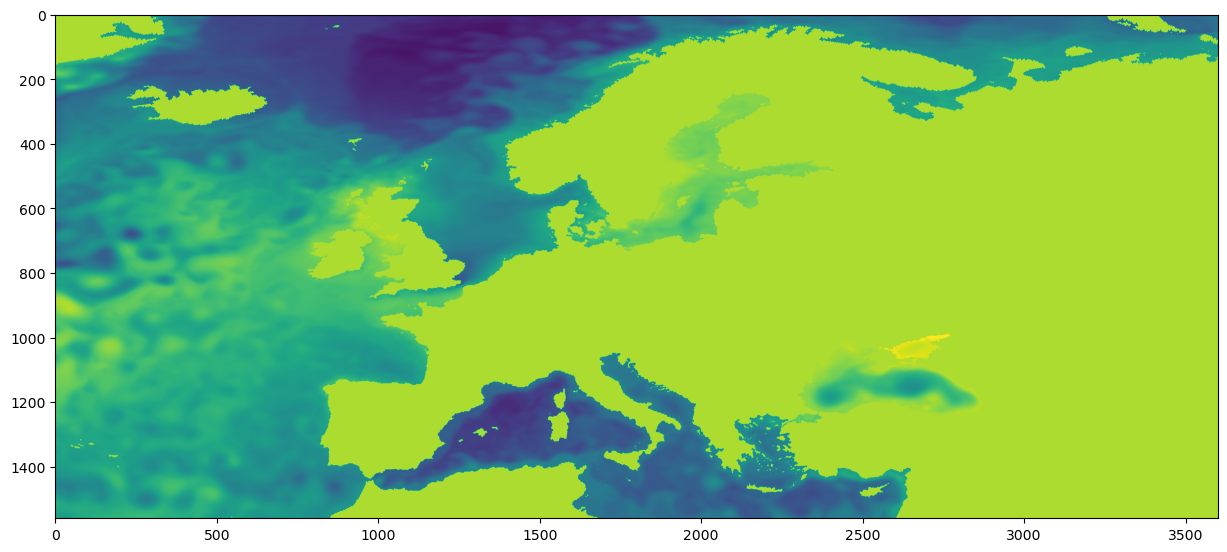

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn),
           vmin=-0.7, vmax=0.1
          )

Looks kind of ugly, we need to mask the land, but this involves a bit more involved method.

## Masking land

This is KDTree based interpolation. Advantage here is that we compute indexes once and then reuse them.

In [8]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [9]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)), balanced_tree=False, compact_nodes=False)
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [10]:
from scipy.spatial import cKDTree

We compute indexes of source grid that are closest to the target grid and distances between them:

In [11]:
distances, inds = create_indexes_and_distances(model_lon_icon, model_lat_icon, lon2, lat2, k=1, workers=10)

In [12]:
# We don't want to use points that are more than 5km away from target grid points
radius_of_influence=10000
# just seelct corresponding indexes from the data, that's you neares neighbor interpolation
data_interpolated = data_sample.values[inds]
# mask all points that get values from more than 5km away
data_interpolated[distances >= radius_of_influence] = np.nan
# reshape our vector bach to 2 dimensional array
data_interpolated = data_interpolated.reshape(lon2.shape)
# convert to masked array
data_interpolated = np.ma.masked_invalid(data_interpolated)

Well, a bit nicer :)

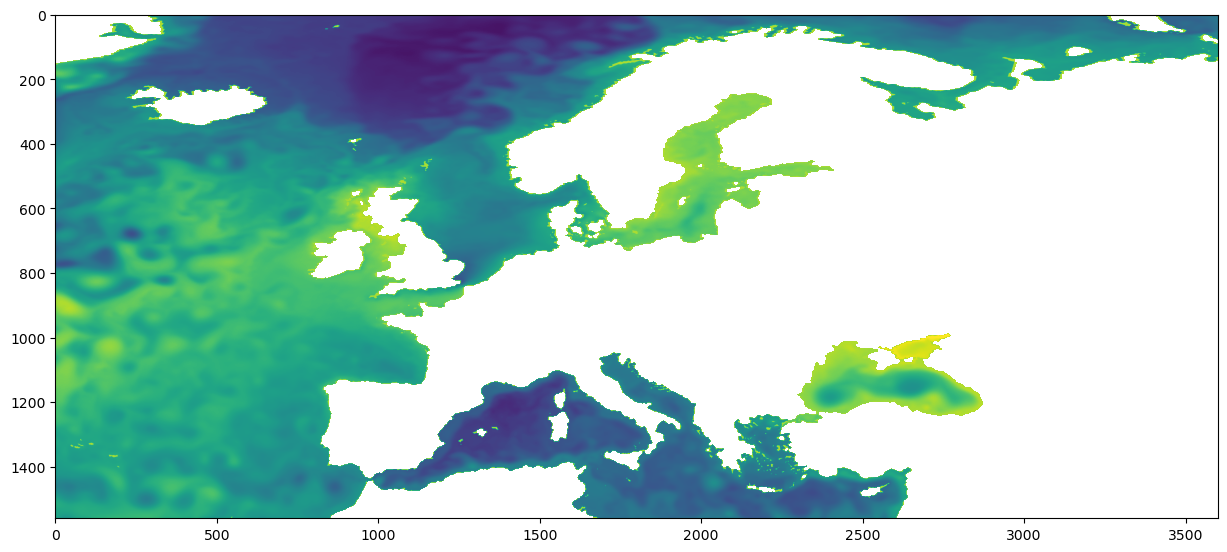

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated), vmin=-0.7, vmax=0.1)